# **Large Additive Distance Phylogeny Problem**
Given an *n* x *n* matrix *D* = [*d<sub>i,j</sub>*], find a tree *T* with *n* leaves and edge weights such that *d<sub>T</sub>*(*i,j*) = *d<sub>i,j</sub>*.



In [89]:
# Can only be applied to additive matrices
def is_additive(D):
    """
    Returns true if the square matrix D is additive

    :param: D is an n x n dict of dicts of ints
    :return: true if D is an additive distance matrix
    """
    n = len(D)
    e = list(D.keys())

    for i in range(n):
        for j in range(i + 1, n):
            for k in range(j + 1, n):
                for l in range(k + 1, n):
                    if (D[e[i]][e[j]] + D[e[k]][e[l]] <= D[e[i]][e[k]] + D[e[j]][e[l]] and D[e[i]][e[k]] + D[e[j]][e[l]] == D[e[i]][e[l]] + D[e[j]][e[k]]):
                        continue
                    else:
                        print(e[i])
                        print(e[j])
                        print(e[k])
                        print(e[l])
                        return False
    return True

def trim(D, delta):
    """
    Returns matrix with all non-zero values trimmed by 2 * delta

    :param: D is an n x n dict of dict of ints
    :param: delta is the trimming parameter
    :return: D after trimming 2 * delta
    """
    if len(D) > 2:
        elems = D.keys()
        for i in elems:
            for j in elems:
                val = D[i][j]
                if val > 0:
                    D[i][j] = val - (2 * delta)
    return D

def find_degenerate(D):
    """
    Returns the degenerate element to next be removed in matrix D

    :param: D is an n x n dict of dicts of ints
    :return: degenerate 3-tuple (i, j, k)
    :return: -1, if D has less than 3 elements or has no degenerate triples
    """
    n = len(D)
    if n < 3:
        return (-1, -1, -1)
    elems = D.keys()
    for i in elems:
        for j in elems:
            for k in elems:
                if i == j or j == k or i == k:
                    continue
                else:
                    if D[i][j] + D[j][k] == D[i][k]:
                        return (i, j, k)
    return (-1, -1, -1)

def is_degenerate(D):
    """
    Returns the degenerate state of matrix D

    :param: D is an n x n dict of dicts of ints
    :return: True, if D is degenerate - False, if D is not degenerate
    """
    return find_degenerate(D) != (-1, -1, -1)

def find_trimming_param(D):
    """
    Returns the degenerate element to next be removed in matrix D

    :param: D is an n x n dict of dicts of ints
    :return: the smallest delta (trimming parameter) of matrix D
    :return: -1, if D has less than 3 elements
    """
    n = len(D)
    if n < 3:
        return -1
    min_delta = float("inf")
    elems = D.keys()
    for i in elems:
        for j in elems:
            for k in elems:
                if i == j or j == k or i == k:
                    continue
                else:
                    delta = (D[i][j] + D[j][k] - D[i][k]) / 2
                    if delta < min_delta:
                        min_delta = delta
    return int(min_delta)

def remove_degenerate(D, degenerate):
    """
    Removes the degenerate element from matrix D

    :param: D is an n x n dict of dicts of ints
    :return: matrix D after removing the degenerate element
    """
    D.pop(degenerate)
    for elem in D.keys():
        D[elem].pop(degenerate)
    return D

def print_matrix(D):
    print('\n')
    for elem in D.keys():
        print(D[elem])
    print('\n')

In [90]:
import matplotlib.pyplot as plt
import networkx as nx

def additive_phylogeny_helper(D):
    """
    Performs the additive phylogeny algorithm on matrix D

    :param: D is an n x n dict of dicts of ints
    :return: graph G of distance matrix D
    """
    # base case + create graph
    if len(D) < 3:
        if len(D) == 1:
            G = nx.Graph()
            G.add_node(list(D.keys())[0])
            return G
        nodes = list(D.keys())
        i, j = nodes[0], nodes[1]
        G = nx.Graph()
        G.add_nodes_from(nodes)
        G.add_weighted_edges_from([(i, j, D[i][j])])
        return G
    # check if degenerate, trim if not
    delta = find_trimming_param(D)
    if not is_degenerate(D):
        D = trim(D, delta)
    # remove degenerate triple
    degen_triple = find_degenerate(D)
    i, j, k = degen_triple[0], degen_triple[1], degen_triple[2]
    dist = D[i][j]
    remove_degenerate(D, j)
    # recurse until base case is hit
    G = additive_phylogeny(D)
    # add inner node v at dist on path from i to k
    path = nx.shortest_path(G, i, k)
    v = str(G.number_of_nodes() + G.number_of_edges())
    for idx in range(len(path) - 1):
        curr_dist = G.get_edge_data(path[idx], path[idx + 1])['weight']
        if dist <= curr_dist:
            G.add_node(v)
            G.add_weighted_edges_from([(path[idx], v, dist),
                                       (v, path[idx + 1], curr_dist - dist)])
            G.remove_edge(path[idx], path[idx + 1])
            break
        else:
            dist = dist - curr_dist
    # re-add node j connected to v
    G.add_node(j)
    G.add_weighted_edges_from([(v, j, 0)])
    leaves = [node for node in G.nodes() if G.degree(node) == 1]
    # extend hanging edges
    for leaf in leaves:
        adj = list(G.neighbors(leaf))[0]
        curr_weight = G.get_edge_data(leaf, adj)['weight']
        G.remove_edge(leaf, adj)
        G.add_weighted_edges_from([(leaf, adj, curr_weight + delta)])
    return G

def additive_phylogeny(D):
    """
    Checks for additive property of D then performs additive phylogeny algorithm on it

    :param: D is an n x n dict of dicts of ints
    :return: graph G of distance matrix D, or False if D is not additive
    """
    return additive_phylogeny_helper(D)

def draw_graph(G):
    """
    Draws graph G using networkx

    :param: G is a networkx graph
    """
    if isinstance(G, str):
        print(G)
        return
    color_map = []
    node_labels = {}
    node_sizes = []
    for node in G.nodes():
        if not node.isnumeric():
            color_map.append('green')
            node_labels[node] = node
            node_sizes.append(400)
        else:
            color_map.append('gray')
            node_sizes.append(100)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels = False, node_color=color_map, font_weight='bold', node_size=node_sizes)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels = labels)
    nx.draw_networkx_labels(G, pos, node_labels)
    plt.show()



{'a': 0, 'b': 4, 'c': 10, 'd': 9}
{'a': 4, 'b': 0, 'c': 8, 'd': 7}
{'a': 10, 'b': 8, 'c': 0, 'd': 9}
{'a': 9, 'b': 7, 'c': 9, 'd': 0}




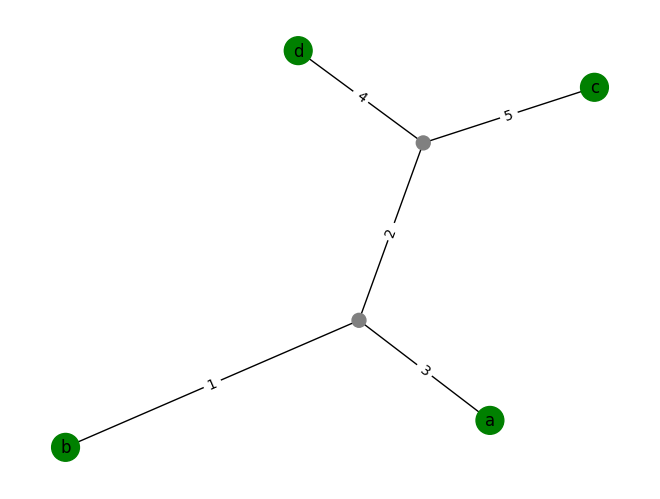



{'a': 0, 'b': 2, 'c': 4, 'd': 4}
{'a': 2, 'b': 0, 'c': 4, 'd': 4}
{'a': 4, 'b': 4, 'c': 0, 'd': 2}
{'a': 4, 'b': 4, 'c': 2, 'd': 0}




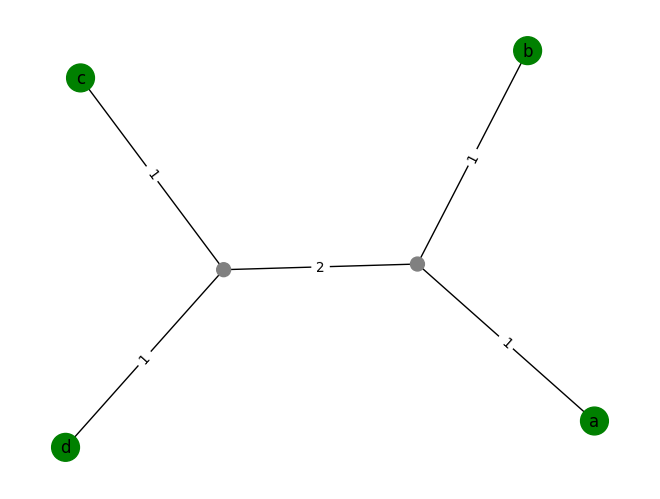



{'a': 0, 'b': 11, 'c': 10, 'd': 9, 'e': 15}
{'a': 11, 'b': 0, 'c': 3, 'd': 12, 'e': 18}
{'a': 10, 'b': 3, 'c': 0, 'd': 11, 'e': 17}
{'a': 9, 'b': 12, 'c': 11, 'd': 0, 'e': 8}
{'a': 15, 'b': 18, 'c': 17, 'd': 8, 'e': 0}




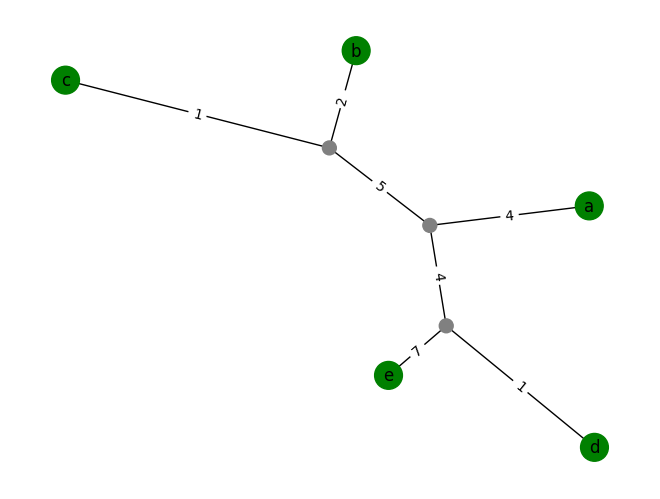



{'a': 0, 'b': 3, 'c': 4, 'd': 7, 'e': 11, 'f': 9}
{'a': 3, 'b': 0, 'c': 5, 'd': 8, 'e': 12, 'f': 10}
{'a': 4, 'b': 5, 'c': 0, 'd': 5, 'e': 9, 'f': 7}
{'a': 7, 'b': 8, 'c': 5, 'd': 0, 'e': 10, 'f': 8}
{'a': 11, 'b': 12, 'c': 9, 'd': 10, 'e': 0, 'f': 4}
{'a': 9, 'b': 10, 'c': 7, 'd': 8, 'e': 4, 'f': 0}




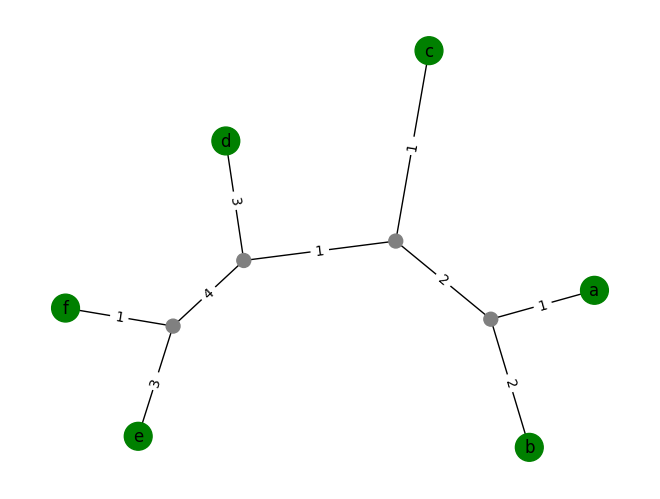

In [92]:
D1 = {
    'a':{ 'a':0, 'b':4, 'c':10, 'd':9 },
    'b':{ 'a':4, 'b':0, 'c':8, 'd':7 },
    'c':{ 'a':10, 'b':8, 'c':0, 'd':9 },
    'd':{ 'a':9, 'b':7, 'c':9, 'd':0 }
}

print_matrix(D1)
G1 = additive_phylogeny(D1)

draw_graph(G1)

D2 = {
    'a':{ 'a':0, 'b':2, 'c':4, 'd':4 },
    'b':{ 'a':2, 'b':0, 'c':4, 'd':4 },
    'c':{ 'a':4, 'b':4, 'c':0, 'd':2 },
    'd':{ 'a':4, 'b':4, 'c':2, 'd':0 }
}

print_matrix(D2)
G2 = additive_phylogeny(D2)

draw_graph(G2)

D3 = {
    'a':{ 'a':0, 'b':11, 'c':10, 'd':9, 'e':15 },
    'b':{ 'a':11, 'b':0, 'c':3, 'd':12, 'e':18 },
    'c':{ 'a':10, 'b':3, 'c':0, 'd':11, 'e':17 },
    'd':{ 'a':9, 'b':12, 'c':11, 'd':0, 'e':8 },
    'e':{ 'a':15, 'b':18, 'c':17, 'd':8, 'e':0 }
}

print_matrix(D3)
G3 = additive_phylogeny(D3)

draw_graph(G3)

D4 = {
    'a':{ 'a':0, 'b':3, 'c':4, 'd':7, 'e':11, 'f':9 },
    'b':{ 'a':3, 'b':0, 'c':5, 'd':8, 'e':12, 'f':10 },
    'c':{ 'a':4, 'b':5, 'c':0, 'd':5, 'e':9, 'f':7 },
    'd':{ 'a':7, 'b':8, 'c':5, 'd':0, 'e':10, 'f':8 },
    'e':{ 'a':11, 'b':12, 'c':9, 'd':10, 'e':0, 'f':4 },
    'f':{ 'a':9, 'b':10, 'c':7, 'd':8, 'e':4, 'f':0 }
}

print_matrix(D4)
G4 = additive_phylogeny(D4)

draw_graph(G4)